# Basic Classifier Implementation
> **Created** by Fan Yang on 2025-06-04  
> **Edited** by Mario Boley on 2025-06-08

The goal of this study is to provide a basic rule classifier implementation compatible with the `scikit-learn` using the early `optikon` interface.

## Example Data

(100, 2) (100,)


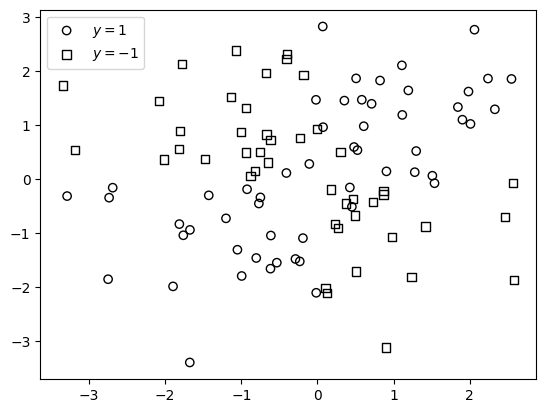

In [8]:
import numpy as np
from scipy.special import expit
from matplotlib import pyplot as plt

RNG = np.random.default_rng(seed=0)
x = RNG.multivariate_normal([0, 0], 2*np.eye(2), size=100)
y = 2 * RNG.binomial(1, expit(10*x[:, 0]*x[:, 1])) - 1 # RNG.choice([-1,1],size=100)
print(x.shape, y.shape)

plt.scatter(x[y>0, 0], x[y>0, 1], marker='o', fc='None', ec='black', label='$y=1$')
plt.scatter(x[y<=0, 0], x[y<=0, 1], marker='s', fc='None', ec='black', label='$y=-1$')
plt.legend()
plt.show()

In [9]:
from sklearn.linear_model import LogisticRegression

linear = LogisticRegression().fit(x, y)
print(linear.coef_)
np.array_equal(linear.predict(x), (linear.predict_proba(x)[:, 1] >= 0.5))

[[ 0.15096096 -0.06199931]]


False

In [10]:
from optikon import max_weighted_support, equal_width_propositionalization

props = equal_width_propositionalization(x)
key, _, _ ,_ = max_weighted_support(x, y, props, max_depth=5)
print(props.str_from_conj(key))
props[key].support_all(x)

x1 >= 0.307 & x2 >= 0.093


array([ 1,  3,  9, 10, 12, 16, 17, 19, 21, 23, 24, 26, 28, 33, 35, 39, 43,
       47, 50, 56, 58, 59, 60, 66, 67, 68, 70, 71, 84, 86])

## Label Encoder

The next cell demonstrate the use of `sklearn.preprocessing.LabelEncoder`

In [11]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
original_labels = [-1, 1, -1, 1, -1]
encoded = le.fit_transform(original_labels)
print(encoded) 

print(le.classes_)

[0 1 0 1 0]
[-1  1]


## Integration into a Classifier

This is the basic classifier interface. Current limitations

- No robust treatment of negative label convention and saving of class codes. For comparison `scikit-learn` uses `sklearn.utils.multiclass.unique_labels` to store labels provided during fitting (in order) in `self.classes_`

- No `predict_proba`

- Should probably use `BaseEstimator` and `ClassifierMixin` for defined behaviour and lean code base

- No background (intercept) rule (but this is not Classifier specific and should be tackled later)

In [12]:
import scipy
import scipy.optimize
from sklearn.preprocessing import LabelEncoder

class RuleBoostingClassificer:

    def __init__(self, num_rules=3, max_depth=5):
        self.num_rules = num_rules
        self.max_depth = max_depth

    def _preprocess_labels(self, y):
        if len(np.unique(y)) == 2:
            le = LabelEncoder()
            labels = le.fit_transform(y)
        else:
            labels = np.unique(y)
        return labels
    
    def _get_risk(self, y, q_mat):
        def sum_loss(weight_vec):
            return np.sum(np.log(1 + np.exp((q_mat.dot(weight_vec)))) - y * (q_mat.dot(weight_vec)))
        return sum_loss

    def _get_gradient(self, y, q_mat):
        def gradient(weight_vec):
            grad_vec = expit((q_mat.dot(weight_vec))) - y
            return q_mat.T.dot(grad_vec)
        return gradient
    
    def _get_hessian(self, y, q_mat):
        def hessian(weight_vec):
            sig = expit(-y * (q_mat.dot(weight_vec)))
            h_vec = sig * (1.0 - sig)
            return q_mat.T.dot(np.diag(h_vec)).dot(q_mat) 
        return hessian

    def fit(self, x, y):
        labels = self._preprocess_labels(y)
        n = len(x)
        props = equal_width_propositionalization(x)
        self.q_ = []

        q_matrix = np.zeros(shape=(n, self.num_rules))
        self.coef_ = np.zeros(shape=0)
        for i in range(self.num_rules):
            # this is a bit shaky in the first iteration but seems to work as intended
            # should get more robust once one adds a background rule
            y_hat = q_matrix[:, :i].dot(self.coef_) 
            g = expit(y_hat) - labels 

            opt_key_pos, opt_val_pos, _, _ = max_weighted_support(x, g, props, self.max_depth)
            opt_key_neg, opt_val_neg, _, _ = max_weighted_support(x, -g, props, self.max_depth)
            if opt_val_pos >= opt_val_neg:
                self.q_.append(props[opt_key_pos])
            else:
                self.q_.append(props[opt_key_neg])

            q_matrix[self.q_[i].support_all(x), i] = 1
            risk_func = self._get_risk(labels, q_matrix[:, :i+1])
            gradient_func = self._get_gradient(labels, q_matrix[:, :i+1])
            hessian_func = self._get_hessian(labels, q_matrix[:, :i+1])
            w = np.append(self.coef_[:i], 0.0)
            self.coef_ = scipy.optimize.minimize(risk_func, w, method='Newton-CG', jac=gradient_func, hess=hessian_func,
                                        options={'disp': False, 'xtol': 1e-6, 'maxiter': 100}).x
        return self
    
    def predict(self, x):
        n = len(x)
        q_matrix = np.zeros(shape=(n, len(self.q_)))
        for i in range(len(self.q_)):
            q_matrix[self.q_[i].support_all(x), i] = 1
        return (q_matrix.dot(self.coef_) > 0).astype(int) 
    
    def __str__(self):
        res = ''
        for i in range(len(self.q_)):
            res += f'{self.coef_[i]:+.3f} if {self.q_[i].str_from_conj(np.arange(len(self.q_[i])))} \n'
        return res
    
    def __repr__(self):
        return f'RuleBoostingClassificer({self.num_rules}, {self.max_depth})'

rb_classifier = RuleBoostingClassificer(num_rules=3).fit(x, y)
print(rb_classifier)
rb_classifier

+3.867 if x1 >= 0.307 & x2 >= 0.093 
-4.845 if x1 <= 0.452 & x2 >= 0.093 & x2 <= 2.707 
+1.370 if x1 <= 0.452 & x2 <= 1.836 



RuleBoostingClassificer(3, 5)

In [13]:
rb_classifier.predict(x)

array([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0])

## Integration of Regularisation

Classifier with L2 regularization of the weight vector.

In [14]:
class RuleBoostingClassificerRegularization:

    def __init__(self, num_rules=3, max_depth=5, reg=0.1):
        self.num_rules = num_rules
        self.max_depth = max_depth
        self.reg = reg

    def _preprocess_labels(self, y):
        if len(np.unique(y)) == 2:
            le = LabelEncoder()
            labels = le.fit_transform(y)
        else:
            labels = np.unique(y)
        return labels
    
    def _get_risk(self, y, q_mat):
        def sum_loss(weight_vec):
            y_hat = q_mat.dot(weight_vec)
            return np.sum(np.log(1 + np.exp(y_hat)) - y * y_hat)+ self.reg * (weight_vec ** 2).sum() / 2
        return sum_loss

    def _get_gradient(self, y, q_mat):
        def gradient(weight_vec):
            grad_vec = expit((q_mat.dot(weight_vec)))-y
            return q_mat.T.dot(grad_vec) + self.reg * weight_vec
        return gradient
    
    def _get_hessian(self, y, q_mat):
        def hessian(weight_vec):
            sig = expit(-y * (q_mat.dot(weight_vec)))
            h_vec = sig * (1.0 - sig)
            return q_mat.T.dot(np.diag(h_vec)).dot(q_mat) + np.diag([self.reg] * len(weight_vec))
        return hessian
    
    def fit(self, x, y):
        n = len(x)
        labels = self._preprocess_labels(y)
        props = equal_width_propositionalization(x)
        self.q_ = []

        q_matrix = np.zeros(shape=(n, self.num_rules))
        self.coef_ = np.zeros(shape=0)
        for i in range(self.num_rules):
            # this is a bit shaky in the first iteration but seems to work as intended
            # should get more robust once one adds a background rule
            y_hat = q_matrix[:, :i].dot(self.coef_) 
            g = expit(y_hat) - labels

            opt_key_pos, opt_val_pos, _, _ = max_weighted_support(x, g, props, self.max_depth)
            opt_key_neg, opt_val_neg, _, _ = max_weighted_support(x, -g, props, self.max_depth)
            if opt_val_pos >= opt_val_neg:
                self.q_.append(props[opt_key_pos])
            else:
                self.q_.append(props[opt_key_neg])

            q_matrix[self.q_[i].support_all(x), i] = 1
            risk = self._get_risk(labels, q_matrix[:, :i+1])
            gradient = self._get_gradient(labels, q_matrix[:, :i+1])
            hessian = self._get_hessian(labels, q_matrix[:, :i+1])
            w = np.append(self.coef_[:i], -1.0)
            self.coef_ = scipy.optimize.minimize(risk, w, method='Newton-CG', jac=gradient, hess=hessian,
                                        options={'disp': False, 'xtol': 1e-6, 'maxiter': 100}).x

        return self
    
    def predict(self, x):
        n = len(x)
        q_matrix = np.zeros(shape=(n, len(self.q_)))
        for i in range(len(self.q_)):
            q_matrix[self.q_[i].support_all(x), i] = 1
        return q_matrix.dot(self.coef_)
    
    def __str__(self):
        res = ''
        for i in range(len(self.q_)):
            res += f'{self.coef_[i]:+.3f} if {self.q_[i].str_from_conj(np.arange(len(self.q_[i])))} \n'
        return res
    
    def __repr__(self):
        return f'RuleBoostingClassificerRegularization({self.num_rules}, {self.max_depth})'

rb_classifier_reg = RuleBoostingClassificerRegularization(num_rules=5).fit(x, y)
print(rb_classifier_reg)
rb_classifier_reg

+4.321 if x1 >= 0.307 & x2 >= 0.093 
-4.855 if x1 <= 0.452 & x2 >= 0.093 & x2 <= 2.707 
+2.593 if x1 <= 0.307 & x2 <= 0.965 
-1.808 if x1 >= -1.067 & x2 <= 0.965 
+1.790 if x1 >= -1.067 & x1 <= 0.452 & x2 <= 1.836 



RuleBoostingClassificerRegularization(5, 5)